In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v1', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v1')

In [ ]:
train_ds, test_ds = ds['train'], ds['test']

In [ ]:
import tensorflow as tf

@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label 

In [ ]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [ ]:
import tensorflow as tf

batch_size = 32
buffer_size = 1000

train_ds = train_ds.cache().shuffle(buffer_size).batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for images_batch, labels_batch in train_ds:
  print(images_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
img_shape = (224, 224, 3) 
mobilenet = tf.keras.applications.MobileNet(
    input_shape=img_shape,
    include_top=False,
    weights=None
)

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = mobilenet(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [ ]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
def get_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = mobilenet(inputs)
  x = global_average_layer(x)
  outputs = prediction_layer(x)
  
  return tf.keras.Model(inputs, outputs)

In [ ]:
model = get_model()
lr = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

83

In [ ]:
init_loss, init_acc, init_prec, init_recall = model.evaluate(test_ds)

30/30 [==============================] - 2s 25ms/step - loss: 0.6931 - accuracy: 0.3793 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
print(f"initial loss: {init_loss}")
print(f"initial accuracy: {init_acc}")
print(f"initial precision: {init_prec}")
print(f"initial recall: {init_recall}")

initial loss: 0.6931474804878235
initial accuracy: 0.3862660825252533
initial precision: 0.0
initial recall: 0.0


In [ ]:
epochs = 10
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=test_ds)

Epoch 1/10
32/32 [==============================] - 8s 180ms/step - loss: 0.3314 - accuracy: 0.8523 - precision: 0.8832 - recall: 0.8545 - val_loss: 0.7880 - val_accuracy: 0.3863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 5s 164ms/step - loss: 0.0410 - accuracy: 0.9834 - precision: 0.9880 - recall: 0.9829 - val_loss: 1.1845 - val_accuracy: 0.3863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 5s 166ms/step - loss: 0.0140 - accuracy: 0.9961 - precision: 0.9983 - recall: 0.9949 - val_loss: 1.6661 - val_accuracy: 0.3863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 5s 164ms/step - loss: 0.0145 - accuracy: 0.9951 - precision: 0.9983 - recall: 0.9932 - val_loss: 1.9598 - val_accuracy: 0.3863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 5s 166ms/step - loss

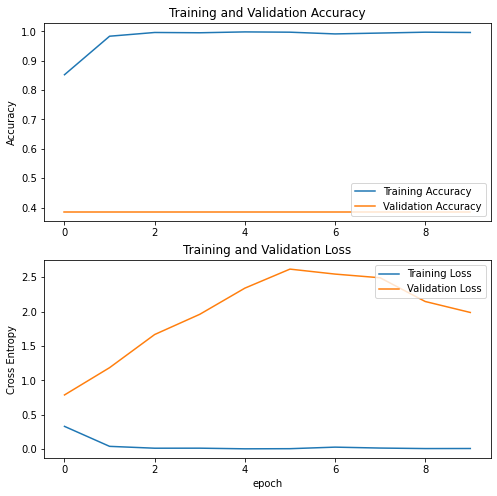

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

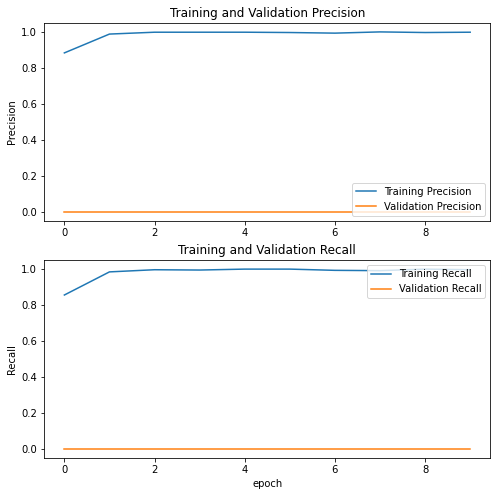

In [ ]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred = model.predict(test_ds.take(1))
print(pred)

[[0.04032337]
 [0.04032449]
 [0.04032327]
 [0.04032319]
 [0.04032375]
 [0.04032408]
 [0.04032464]
 [0.04032351]
 [0.04032372]
 [0.04032398]
 [0.04032396]
 [0.04032447]
 [0.04032375]
 [0.04032449]
 [0.0403249 ]
 [0.04032531]
 [0.04032308]
 [0.04032375]
 [0.04032327]
 [0.04032416]
 [0.04032382]
 [0.04032451]
 [0.04032364]
 [0.0403242 ]
 [0.04032437]
 [0.04032396]
 [0.04032382]
 [0.04032457]
 [0.04032425]
 [0.04032497]
 [0.04032488]
 [0.04032458]]
